## 0. Import libraries 

In [60]:
# Standard Python libraries
import os
from pathlib import Path

# External packages
from garmin_fit_sdk import Decoder, Stream
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

## 1. Define filepaths
1. `activity_directory` is the directory in which the FIT files are located
2. `activity_files` is the individual FIT file you want to work with

In [61]:
activity_directory = r"HealthData\FitFiles\Activities"
activity_files = ["21187155220_ACTIVITY.fit", "21194560398_ACTIVITY.fit",
                  "21581119182_ACTIVITY.fit", "21591616966_ACTIVITY.fit",
                  "21599947988_ACTIVITY.fit", "21614016832_ACTIVITY.fit",
                  "21624787469_ACTIVITY.fit", "21640015305_ACTIVITY.fit",
                  "21653131528_ACTIVITY.fit", "21685821348_ACTIVITY.fit"]

## 2. Define functions

In [62]:
# function to convert semicircle coordinates into decimal degrees (WGS 84)

# Garmin saves its coordinates as semicircles, which reduces storage capacity,
# but it means that we have to convert it into a more useful geometry before we can use it.

def convert_semicircle_to_degrees(semicircle_value):
    return semicircle_value * (180 / 2**31)

In [63]:
# open a FIT file given the parent directory (where it is stored) and the name of the specific file itself

def open_file(parent_directory, filename):
    home = Path.home()
    activity_filepath = os.path.join(home, parent_directory, filename)

    stream = Stream.from_file(activity_filepath)
    decoder = Decoder(stream)
    messages, errors = decoder.read()

    return messages

In [64]:
# extract the coordinates from each file and convert them into a LineString object

def convert_file_to_linestring(parent_directory, filename):
    messages = open_file(parent_directory, filename)

    coordinates = []        # save each coordinate as a tuple in this list

    # add each coordinate to the coordinates list
    i = 0       # keep track of data packets with missing coordinates
    for msg in messages['record_mesgs']:
        try:
            lat = convert_semicircle_to_degrees(msg['position_lat'])
            long = convert_semicircle_to_degrees(msg['position_long'])
        except:     # for some reason, some data packets don't have coordinates in them
            i += 1
        coordinates.append(Point(long, lat))
    line = LineString(coordinates)

    print(f'Number of data packets in {filename} with missing coordinates: {i}')

    return line

In [65]:
# build a GeoDataFrame where each row is a LineString object from one FIT file

def build_dataframe(activity_directory, activity_files):
    linestrings = []

    for file in activity_files:
        linestrings.append(convert_file_to_linestring(activity_directory, file))
    
    indices = list(range(len(linestrings)))

    df_data = {'LineString_Num': indices, 'geometry': linestrings}

    gdf = gpd.GeoDataFrame(df_data, crs="EPSG:4326")        # use WGS 84

    return gdf



## 3. Build GeoDataFrame and plot it

In [66]:
my_gdf = build_dataframe(activity_directory, activity_files)

Number of data packets in 21187155220_ACTIVITY.fit with missing coordinates: 3
Number of data packets in 21194560398_ACTIVITY.fit with missing coordinates: 3
Number of data packets in 21581119182_ACTIVITY.fit with missing coordinates: 0
Number of data packets in 21591616966_ACTIVITY.fit with missing coordinates: 3
Number of data packets in 21599947988_ACTIVITY.fit with missing coordinates: 5
Number of data packets in 21614016832_ACTIVITY.fit with missing coordinates: 2
Number of data packets in 21624787469_ACTIVITY.fit with missing coordinates: 0
Number of data packets in 21640015305_ACTIVITY.fit with missing coordinates: 4
Number of data packets in 21653131528_ACTIVITY.fit with missing coordinates: 4
Number of data packets in 21685821348_ACTIVITY.fit with missing coordinates: 0


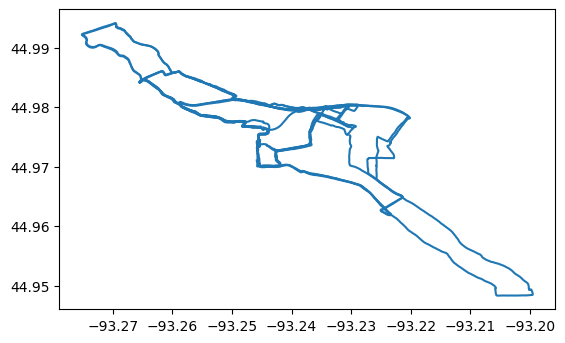

In [67]:
# plot the points

my_gdf.plot(aspect=1, markersize=1)
plt.show()

In [68]:
'''
speed measured in m/s
distance measured in m

'record_mesgs' contains coordinates, etc.

{'timestamp': datetime.datetime(2019, 12, 29, 21, 26, 50, tzinfo=datetime.timezone.utc),
'position_lat': 537257002, 'position_long': -1115376201, 'distance': 0.0, 'altitude': 322.20000000000005,
'speed': 1.185, 'cycle_length16': 0.5, 88: 100, 'heart_rate': 86, 'cadence': 55, 'temperature': 26,
'fractional_cadence': 0.5, 'enhanced_speed': 1.185, 'enhanced_altitude': 322.20000000000005}
'''

"\nspeed measured in m/s\ndistance measured in m\n\n'record_mesgs' contains coordinates, etc.\n\n{'timestamp': datetime.datetime(2019, 12, 29, 21, 26, 50, tzinfo=datetime.timezone.utc),\n'position_lat': 537257002, 'position_long': -1115376201, 'distance': 0.0, 'altitude': 322.20000000000005,\n'speed': 1.185, 'cycle_length16': 0.5, 88: 100, 'heart_rate': 86, 'cadence': 55, 'temperature': 26,\n'fractional_cadence': 0.5, 'enhanced_speed': 1.185, 'enhanced_altitude': 322.20000000000005}\n"